<a href="https://colab.research.google.com/github/UW-geophysics-edu/ess-412-512-intro2seismology/blob/main/Global_Phases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Phases

This notebook will explore gobal propagation of rays as predicted from 1D Earth models and observed in data.

By Marine Denolle (mdenolle@uw.edu) with help of Obspy tutorials and AI

## Ray Tracing

Playbook to solve for ray geometry in 2D vertically varying structure and 3D global Earth. We will use the TauP in Obspy, a python project.



https://docs.obspy.org/packages/obspy.taup.html


In [1]:
## Install dependencies (for Google Colab)
!pip install obspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.1 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.37
    Uninstalling SQLAlchemy-2.0.37:
      Successfully uninstalled SQLAlchemy-2.0.37
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


In [2]:
## Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import obspy


In [3]:
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")
arrivals = model.get_travel_times(source_depth_in_km=55,
                                  distance_in_degree=67)
print(arrivals)

28 arrivals
	P phase arrival at 647.041 seconds
	pP phase arrival at 662.233 seconds
	sP phase arrival at 668.704 seconds
	PcP phase arrival at 674.865 seconds
	PP phase arrival at 794.992 seconds
	PKiKP phase arrival at 1034.098 seconds
	pPKiKP phase arrival at 1050.528 seconds
	sPKiKP phase arrival at 1056.721 seconds
	S phase arrival at 1176.948 seconds
	pS phase arrival at 1195.508 seconds
	SP phase arrival at 1196.830 seconds
	sS phase arrival at 1203.129 seconds
	PS phase arrival at 1205.421 seconds
	SKS phase arrival at 1239.090 seconds
	SKKS phase arrival at 1239.109 seconds
	ScS phase arrival at 1239.512 seconds
	SKiKP phase arrival at 1242.388 seconds
	pSKS phase arrival at 1260.314 seconds
	sSKS phase arrival at 1266.921 seconds
	SS phase arrival at 1437.427 seconds
	PKIKKIKP phase arrival at 1855.271 seconds
	SKIKKIKP phase arrival at 2063.564 seconds
	PKIKKIKS phase arrival at 2069.756 seconds
	SKIKKIKS phase arrival at 2277.857 seconds
	PKIKPPKIKP phase arrival at 2353.93

In [4]:
arrivals = model.get_travel_times(source_depth_in_km=100,
                                  distance_in_degree=45,
                                  phase_list=["P", "PSPSPS"])
print(arrivals)

3 arrivals
	P phase arrival at 485.210 seconds
	PSPSPS phase arrival at 4983.041 seconds
	PSPSPS phase arrival at 5799.249 seconds


In [5]:
arrivals = model.get_ray_paths(500, 130)
arrivals = model.get_pierce_points(500, 130)

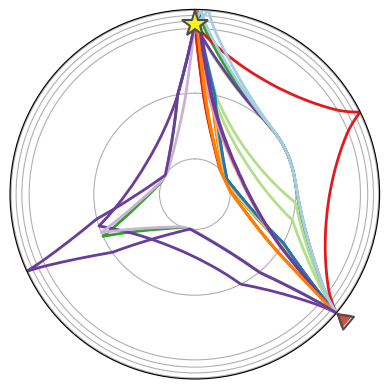

In [6]:
arrivals = model.get_ray_paths(
    source_depth_in_km=500, distance_in_degree=130, phase_list=["ttbasic"])
ax = arrivals.plot_rays()

In [7]:
arrivals = model.get_ray_paths(source_depth_in_km=500,
                               distance_in_degree=130,
                               phase_list=["Pdiff", "Sdiff",
                                           "pPdiff", "sSdiff"])

## Student exercise

Download data from a large earthquakes.

You can find earthquakes on the USGS website: https://www.usgs.gov/programs/earthquake-hazards

Pick a large earthquakes, get his date. Another way to collect earthquake information data is by querying an obspy earthquake catalog

In [17]:
from obspy.clients.fdsn import Client
client = Client("IRIS")

eq = client.get_events(starttime=obspy.UTCDateTime("2023-01-01T00:00:00"),
                       endtime=obspy.UTCDateTime("2025-01-01T00:00:00"),
                       minmagnitude=7.5)

print(eq)
# find the largest magnitude
mags = [e.magnitudes[0].mag for e in eq]
idx = np.argmax(mags)
eq = eq[idx]
starttime = obspy.UTCDateTime(eq[0].origins.time)  # Earthquake origin time
endtime = starttime + 3*3600  # End time (3 hour after origin)

2023-02-06T01:17:34.362000Z


### download waveform data

Using Obspy

In [9]:
st = client.get_waveforms("*", "*", "*", "BHZ", starttime, endtime, event_id=event_id)  # Get BHZ component data

NameError: name 'starttime' is not defined

### Plot all o fthe waveforms

In [ ]:
from obspy.taup import plot_travel_times
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9, 9))
ax = plot_travel_times(source_depth=10, phase_list=["P", "S", "PP"],
                       ax=ax, fig=fig)

## calculate angular distance

In [ ]:
from obspy.geodetics import gps2dist_azimuth

event_latitude = st[0].stats.sac.evla  # Get event latitude from the first trace
event_longitude = st[0].stats.sac.evlo  # Get event longitude

distances = []
for tr in st:
    station_latitude = tr.stats.sac.stla
    station_longitude = tr.stats.sac.stlo
    dist, az, baz = gps2dist_azimuth(event_latitude, event_longitude, station_latitude, station_longitude)
    distances.append(dist / 1000)  # Convert distance to kilometers

## calculate travel times

In [ ]:
model = TauPyModel(model="iasp91")
travel_times = []
for dist in distances:
    arrivals = model.get_travel_times(source_depth_in_km=st[0].stats.sac.evdp, distance_in_degree=obspy.geodetics.kilometer2degrees(dist), phase_list=["P"])
    travel_times.append(arrivals[0].time)

## Plot vertical seismogram

Make a plot of the vertical seismograms as a function of

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, tr in enumerate(st):
    time_shift = travel_times[i]  # Shift the time axis by the travel time
    ax.plot(distances[i], tr.data, "k")  # Plot the trace with an offset for visualization

ax.set_xlabel("Time (s)")
ax.set_ylabel("Angular Distance (°)")
ax.set_title("Vertical Seismograms Aligned by P-wave Travel Time")
plt.show()